In [42]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from functools import partial
import rsciio.digitalmicrograph as dm
from CLspectrum_sim_OOP import *
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from scipy import signal

class CoreLossFitter:
    def __init__(self, E_0, beta):
        '''
        Initializes the CoreLossFitter object with the beam energy E_0 and the collection semi-angle beta
        '''

        self.E_0 = E_0
        self.beta = beta

        self.shifts = []        
        
        self.energy_loss_axis = None
        self.spatial_axis = None

        self.dispersion = None
        self.ionization_energy = None

        self.simulated_edge = None
        self.fitted_background = None
        
        self.isolated_edges = None
        self.isolated_fine_structure = None
        self.core_loss_data = None




    def read_from_dm3(self, file_path):
        '''
        Reads the core loss data from a dm3 file and returns the core loss data, energy loss axis, and spatial axis
        '''

        file = dm.file_reader(file_path)
        self.core_loss_data = file[0]['data']

        # Extracting the energy loss axis and spatial axis
        energy_loss_md = file[0]['axes'][1]
        begin, self.dispersion, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
        self.energy_loss_axis = np.linspace(begin, begin + self.dispersion * (size - 1), size)

        spatial_md = file[0]['axes'][0]
        begin, step, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
        self.spatial_axis = np.linspace(begin, begin + step * (size - 1), size)

        return self.core_loss_data, self.energy_loss_axis, self.spatial_axis
    
    def align_data(self, reference_spectrum_index = 0):
        '''
        Aligns the core loss data by cross-correlating the data with the reference spectrum
        '''
        reference_spectrum = self.core_loss_data[reference_spectrum_index]
        for i, x in enumerate(self.core_loss_data):
            cross_correlate = signal.correlate(x, reference_spectrum, mode='full')
            shift = len(x) - np.argmax(cross_correlate)
            self.core_loss_data[i] = np.roll(x, shift)
            self.shifts.append(shift)

        #window data such that all spectra starts at the same energy loss
        self.window_data(lower = self.energy_loss_axis[max(np.abs(self.shifts))])
        return self.core_loss_data, self.energy_loss_axis
                
    def window_data(self, lower=0, higher=1e6):
        '''
        Windows the core loss data to a specific energy loss range
        '''
        window = (self.energy_loss_axis<higher)&(self.energy_loss_axis>lower)
        self.core_loss_data = self.core_loss_data[:,window]
        self.energy_loss_axis = self.energy_loss_axis[window]
        return self.core_loss_data, self.energy_loss_axis
    
    def normalize_by_first_value(self):
        '''
        Normalizes the core loss data 
        '''
        self.core_loss_data /= self.core_loss_data[:, 0][:, np.newaxis]
        return self.core_loss_data
    
    def get_background_fit(self, minimal_ionization_energy = 100):
        '''
        Fits the background of the core loss data and returns the background fit and the isolated edges
        '''
        self.isolated_edges = np.zeros_like(self.core_loss_data)
        self.background_fit = np.zeros_like(self.core_loss_data)
        max_energy = minimal_ionization_energy-5

        for i,x in enumerate(self.core_loss_data):
            popt, _ = curve_fit(self.background, self.energy_loss_axis[self.energy_loss_axis<max_energy], x[self.energy_loss_axis<max_energy], maxfev = 10000)
            self.background_fit[i] = self.background(self.energy_loss_axis, *popt)
            self.isolated_edges[i] = x-self.background_fit[i]
        return self.background_fit, self.isolated_edges


    def get_simulated_edge(self, element, edge, file_path = 'data/Dirac_GOS.gosh',):
        '''
        Calculates the edge shape according to the element and edge specified with a Generalized oscillator strength.
        Returns the simulated edge and the ionization energy
        '''
        simulation_object = SimulateEELSSpectrum(file_path, element, edge, self.E_0, self.beta)
        simulation_object.create_axes(self.energy_loss_axis[0], self.energy_loss_axis[-1]+self.dispersion, self.dispersion)
        self.simulated_edge, self.ionization_energy = simulation_object.calculate_all_edges()
        return self.simulated_edge, self.ionization_energy
    
    def get_edge_fit(self):
        '''
        Fits the edges of the core loss data to the simulated edges and returns the fitted edges
        '''
        edge_interpolated = interp1d(self.energy_loss_axis, self.simulated_edge/max(self.simulated_edge), kind='linear', fill_value=0, bounds_error=False)

        edge_interpolated_partial = partial(self.edge_model, edge_interpolated=edge_interpolated)

        self.isolated_fine_structure = np.zeros_like(self.isolated_edges)
        
        for i, x in enumerate(self.isolated_edges):
            popt, _ = curve_fit(edge_interpolated_partial, self.energy_loss_axis, x,  maxfev = 10000)
            self.isolated_fine_structure[i] = x-edge_interpolated_partial(self.energy_loss_axis, *popt)
        return self.isolated_fine_structure
    
    def choose_region(self, start, stop):
        '''
        Chooses a specific spatial region of the core loss data'
        '''
        window = (self.spatial_axis<stop)&(self.spatial_axis>start)
        self.core_loss_data = self.core_loss_data[:,window]
        self.spatial_axis = self.spatial_axis[window]
        return self.core_loss_data, self.spatial_axis
    
    def calc_mean_stdev(self):
        '''
        Calculates the mean and standard deviation of the isolated fine structure
        '''
        stdev = np.std(self.isolated_edges, axis=0)
        mean = np.mean(self.isolated_edges, axis=0)
        return mean, stdev
    
    def plot(self, data, axis, title):
        '''
        Plots 3D data with the relative position on the y-axis and the energy loss on the x-axis
        '''
        plt.figure(figsize=(10,5))
        plt.imshow(data, aspect='auto', extent=[axis[0], axis[-1], 0, len(data)], cmap='inferno')
        plt.colorbar()
        plt.title(title)
        plt.xlabel('Energy loss [eV]')
        plt.ylabel('Spatial axis')
        plt.show()

    @staticmethod
    def background(counts, A, r):
        '''
        Power law background model
        '''
        return A*counts**-r
    
    @staticmethod
    def edge_model(E, A, E_shift, edge_interpolated):
        '''
        Model for the edge fitting
        '''
        return (A * edge_interpolated(E - E_shift))

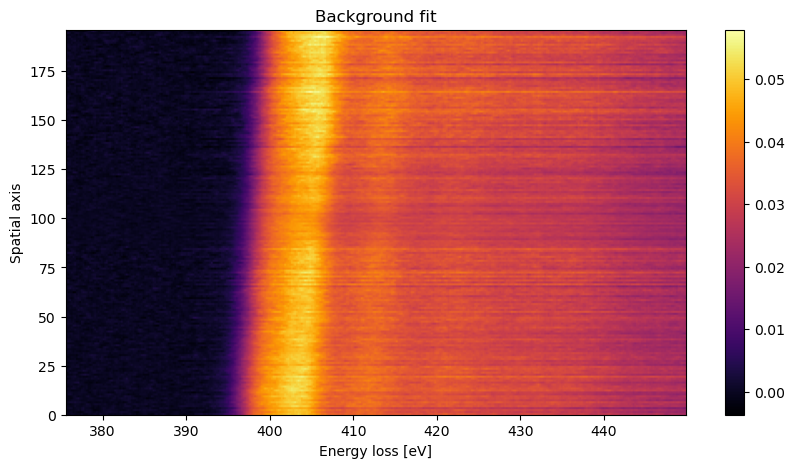

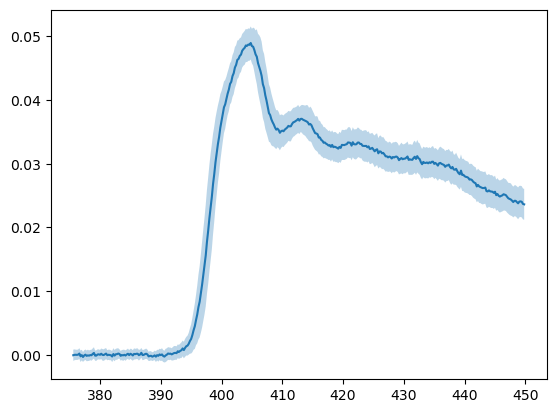

In [43]:
clf = CoreLossFitter(300e3, 10e-3)
clf.read_from_dm3('data/004_core_loss_line_020evpx_5mm.dm3')

aligned_data,energy_loss_axis = clf.align_data()
# clf.plot(aligned_data, energy_loss_axis, 'Aligned core loss data')
clf.normalize_by_first_value()

d, r=clf.window_data(lower = 375, higher = 450)
clf.align_data(-1)
# clf.plot(d, r, 'Windowed core loss data')
_, ionization_energy = clf.get_simulated_edge(element='N', edge='K')
clf.get_background_fit(minimal_ionization_energy = ionization_energy)
clf.plot(clf.isolated_edges, clf.energy_loss_axis, 'Background fit')

# clf.get_edge_fit()
# clf.plot(clf.isolated_fine_structure, clf.energy_loss_axis, 'Edge fit')


plt.plot(clf.energy_loss_axis, clf.calc_mean_stdev()[0])
plt.fill_between(clf.energy_loss_axis, clf.calc_mean_stdev()[0]-clf.calc_mean_stdev()[1], clf.calc_mean_stdev()[0]+clf.calc_mean_stdev()[1], alpha=0.3)

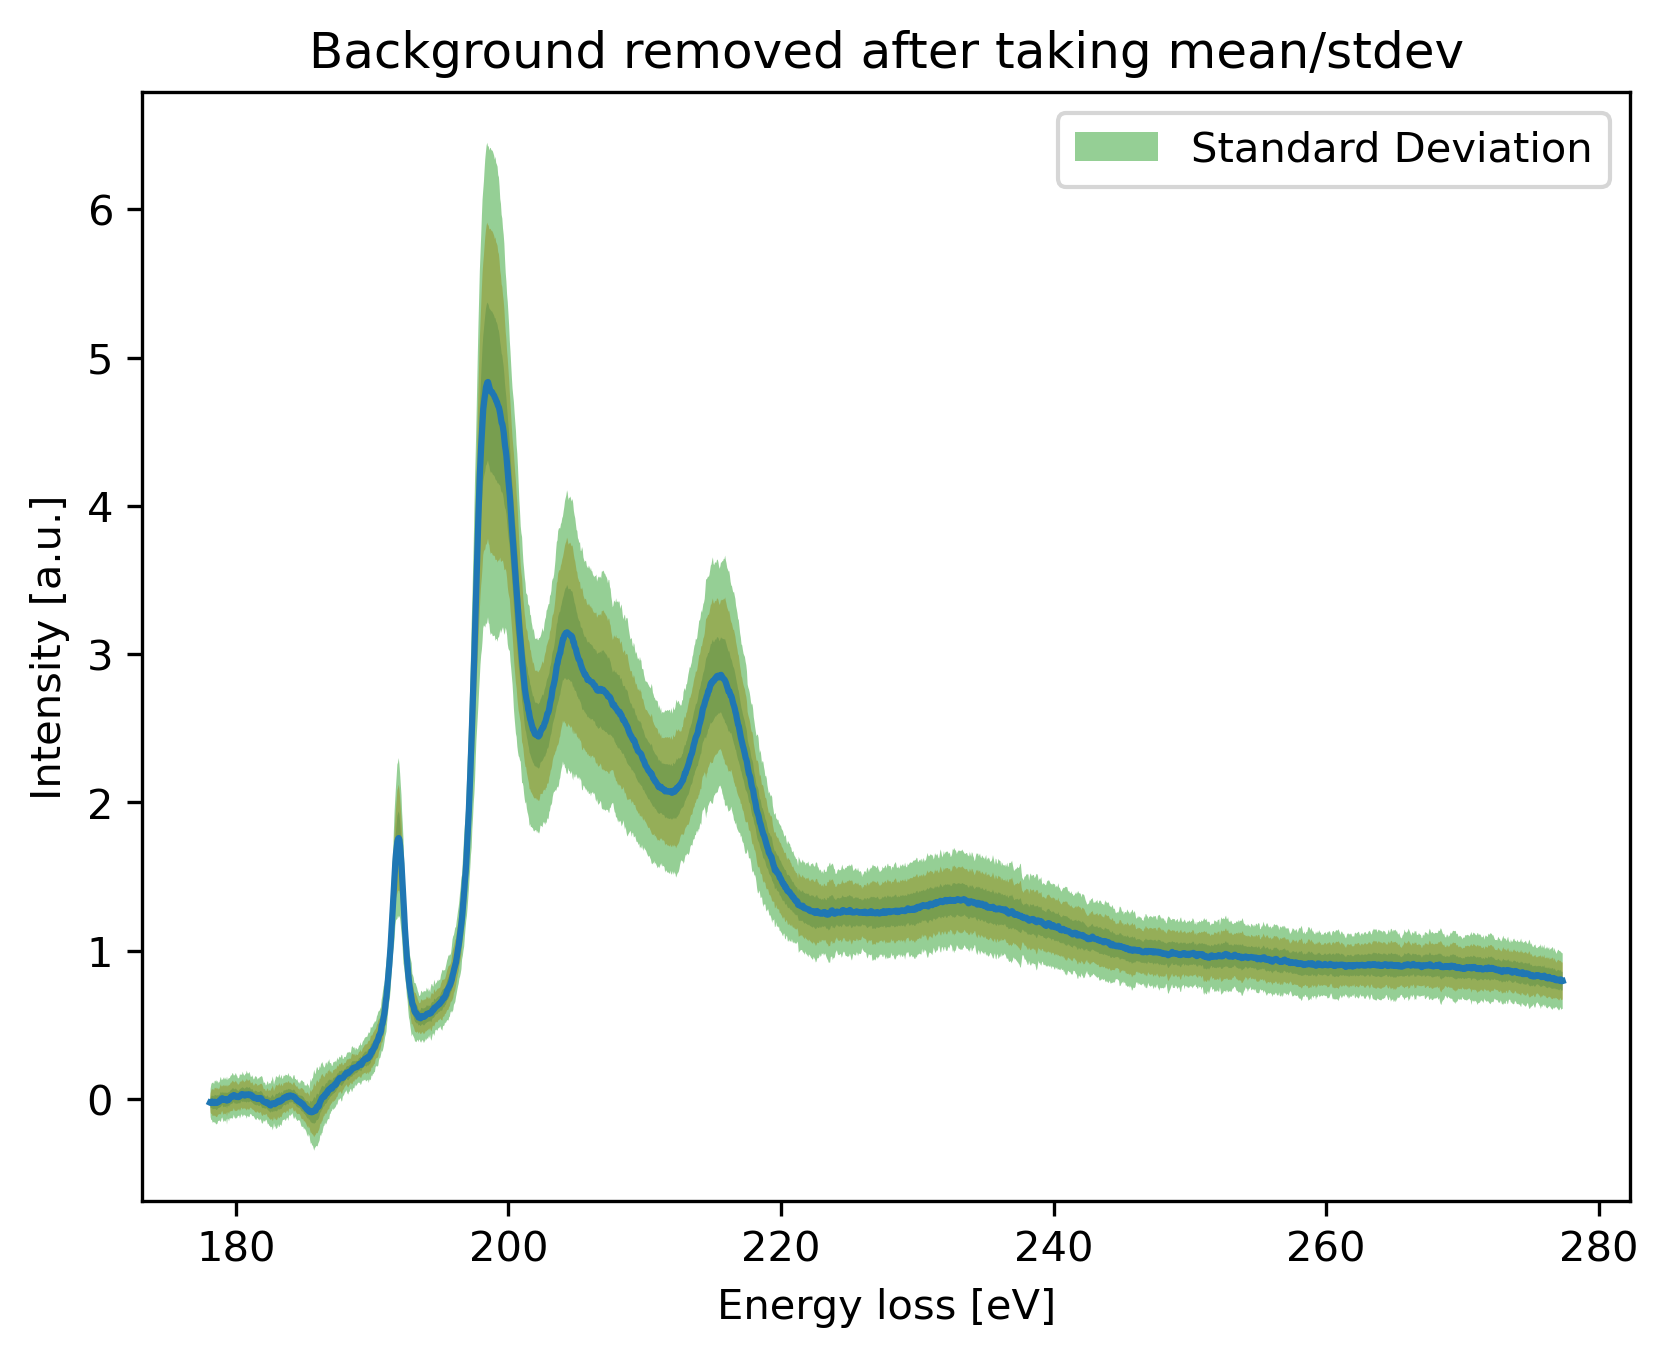

In [40]:
# plt.imshow(aligned_data[:40,:], aspect = 'auto')
single_region = aligned_data[:50,:]
standard_deviation = np.std(single_region, axis = 0)
mean = np.mean(single_region, axis = 0)

def background(counts, A, r):
    return A*counts**-r

popt, pcov = curve_fit(background, energy_loss_axis[energy_loss_axis<ionization_energy-5], mean[energy_loss_axis<ionization_energy-5], maxfev = 10000)
plt.plot(energy_loss_axis, mean-background(energy_loss_axis, *popt))
mean = mean-background(energy_loss_axis, *popt)
# plt.plot(energy_loss_axis, mean, label = 'Mean')
plt.gcf().set_dpi(300)
plt.fill_between(energy_loss_axis, mean-standard_deviation, mean+standard_deviation, alpha = 0.5)
plt.fill_between(energy_loss_axis, mean-2*standard_deviation, mean+2*standard_deviation, alpha = 0.5)
plt.fill_between(energy_loss_axis, mean-3*standard_deviation, mean+3*standard_deviation, alpha = 0.5, label = 'Standard Deviation')
plt.legend()
plt.title('Background removed after taking mean/stdev')
plt.ylabel('Intensity [a.u.]')
plt.xlabel('Energy loss [eV]')
plt.show()


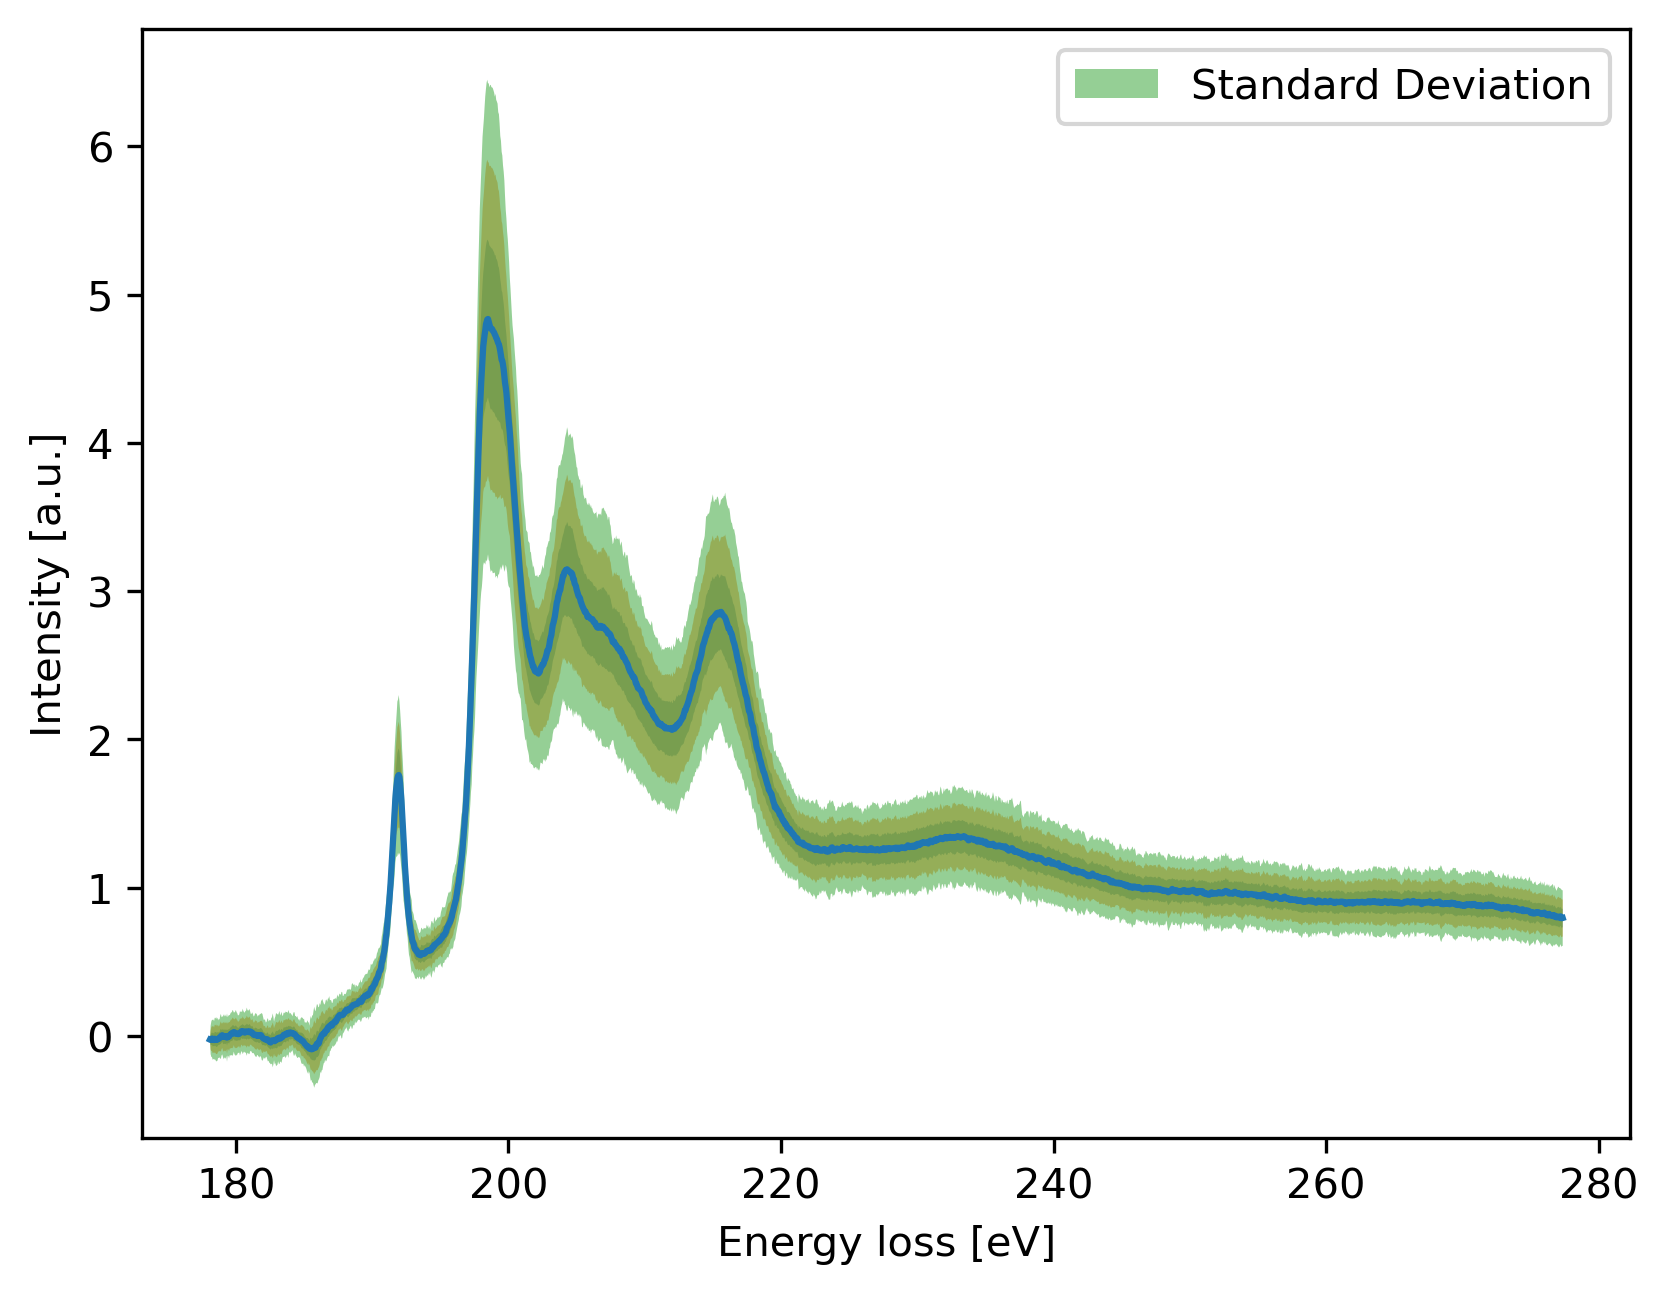

In [42]:
_, isolated_edge = core_loss_fitter_object.get_background_fit(minimal_ionization_energy=ionization_energy)

# isolated_fine_structure = core_loss_fitter_object.get_edge_fit()

mean2 = np.mean(isolated_edge[:50,:], axis = 0)
standard_deviation2 = np.std(isolated_edge[:50,:], axis = 0)

plt.plot(energy_loss_axis, mean)
plt.fill_between(energy_loss_axis, mean-standard_deviation, mean+standard_deviation, alpha = 0.5)
plt.fill_between(energy_loss_axis, mean-2*standard_deviation, mean+2*standard_deviation, alpha = 0.5)
plt.fill_between(energy_loss_axis, mean-3*standard_deviation, mean+3*standard_deviation, alpha = 0.5, label = 'Standard Deviation')
# plt.plot(energy_loss_axis, mean2)
plt.legend()
plt.ylabel('Intensity [a.u.]')
plt.xlabel('Energy loss [eV]')
# plt.title('Background removed before taking mean/stdev')
plt.gcf().set_dpi(300)
plt.show()
